# Input loading

In [2]:
import pandas as pd

print('loading train...', flush=True, end='')

# x를 loading해서 (batch_size, step, channel)
input_path = '../DL_model/dataset/preprocess4/input2/'
x_train = np.load(input_path+'x_train.npz', allow_pickle=True)['arr_0']
x_test = np.load(input_path+'x_test.npz', allow_pickle=True)['arr_0']
x_val = np.load(input_path+'x_val.npz', allow_pickle=True)['arr_0']

gender_train = np.load(input_path+'gender_train.npz', allow_pickle=True)['arr_0']
gender_test = np.load(input_path+'gender_test.npz', allow_pickle=True)['arr_0']
gender_val = np.load(input_path+'gender_val.npz', allow_pickle=True)['arr_0']

age_train = np.load(input_path+'age_train.npz', allow_pickle=True)['arr_0']
age_test = np.load(input_path+'age_test.npz', allow_pickle=True)['arr_0']
age_val = np.load(input_path+'age_val.npz', allow_pickle=True)['arr_0']

y_train = np.load(input_path+'y_train.npz')['arr_0']
y_test = np.load(input_path+'y_test.npz')['arr_0']
y_val = np.load(input_path+'y_val.npz')['arr_0']
print('done', flush=True)

print('x_train shape:', x_train.shape)
print('x_test.shape:', x_test.shape)
print('x_val.shape:', x_val.shape)

# binary classification
y_train_bin = y_train >= 4
y_test_bin = y_test >= 4
y_val_bin = y_val >= 4

loading train...done
x_train shape: (74636, 5000, 2)
x_test.shape: (8795, 5000, 2)
x_val.shape: (7955, 5000, 2)


In [3]:
x_train_ppg = x_train[:,:,0:1]
x_val_ppg = x_val[:,:,0:1]
x_test_ppg = x_test[:,:,0:1]

x_train_ecg = x_train[:,:,1:2]
x_val_ecg = x_val[:,:,1:2]
x_test_ecg = x_test[:,:,1:2]

# GPU setting

In [4]:
from keras.models import Sequential
from keras.models import Model, load_model
from keras.optimizers import Adam as Adam
from keras.layers import Dense, Conv1D, MaxPooling1D, GlobalMaxPool1D, BatchNormalization, Dropout, Activation
from keras.layers import GlobalAveragePooling1D, Flatten, SeparableConv1D, LeakyReLU, UpSampling1D
from keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import auc, classification_report, confusion_matrix, accuracy_score, roc_curve, roc_auc_score, f1_score, precision_recall_curve
import tensorflow as tf
import os, pickle
from keras import backend as K
from keras import regularizers
from keras.initializers import he_normal, GlorotNormal


import tensorflow as tf

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)


4 Physical GPUs, 4 Logical GPUs


# Convolutional autoencoder

## Training

In [33]:
##### from keras.models import Sequential
from keras.models import Model, load_model
from keras.optimizers import Adam as Adam
from keras.layers import Dense, Conv1D, MaxPooling1D, GlobalMaxPool1D, BatchNormalization, Dropout, Activation
from keras.layers import GlobalAveragePooling1D, Flatten, SeparableConv1D, LeakyReLU, Conv1DTranspose
from keras.layers import Input, concatenate, Layer
from keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import auc, classification_report, confusion_matrix, accuracy_score, roc_curve, roc_auc_score, f1_score, precision_recall_curve
import tensorflow as tf
import os, pickle
from keras import backend as K
from keras import regularizers
from keras.initializers import he_normal, GlorotNormal
import tensorflow_addons as tfa

# hyperparamters
num_nodes = [16,32,32] #, 64, 64, 64]
kernel_size = 3
kernels = [11,13,11]
strides = [5,5,5]
pool_size = 2
BATCH_SIZE = 1024
dense_node = 0
dense_node2 = 0
dropout_cnn = 0
dropout_fc = 0
dropout_fc2 = 0
learning_rate = 0.001


# initializer & regularizer
k_init = he_normal(seed=None)
#k_init = GlorotNormal(seed=None) # Xavier normal initializer
#k_init = None
b_init = None
k_l2 = 0
#k_reg = regularizers.l2(l2=k_l2)
k_reg = None
b_reg = None


testname = '-'.join([str(num_node) for num_node in num_nodes])
print(testname)



# 출력 폴더를 생성
model_name = '1D_CNN_ecg_3class_'
for idx, num_node in enumerate(num_nodes):
    model_name += 'conv{}_filter{}_stride{}_'.format(num_node, kernels[idx],strides[idx])
model_name += 'bn_maxpool{}_globalaverage_pool_dense{}_batch{}_lr_{}_kinit'.format(pool_size, dense_node, BATCH_SIZE, learning_rate)

#model_name = 'model_reg_{}_{}_{}_size{}_relu_bn_maxpool{}_globalmaxpool_dense32_dropout{}_batch{}_learning_rate{}'.format(num_nodes[0], num_nodes[1], num_nodes[2], kernel_size, pool_size, dropout_rate, BATCH_SIZE, learning_rate)
save_dir = "output/autoencoder/input2/"
save_path = save_dir+model_name

if not os.path.exists(save_path):
    os.mkdir(save_path)
weight_path = save_path + "/weights.hdf5"


# GPU 설정
strategy = tf.distribute.MirroredStrategy(devices=["/gpu:2","/gpu:3"])
with strategy.scope():
    
    # encoder
    #inp_fnn = Input(shape=(agender_train.shape[1],))
    inp_cnn = Input(shape=(x_train_ecg.shape[1], x_train_ecg.shape[2]))
    
    #out_fnn = inp_fnn
    #out_fnn = Activation('sigmoid') (out_fnn)
    
    out_inc = inp_cnn
    for idx, num_node in enumerate(num_nodes):
        #out_cnn = Conv1D(filters=num_node, kernel_size=kernels[idx], padding='same', kernel_initializer=k_init) (out_cnn)
        out_inc = Conv1D(filters=num_node, kernel_size=kernels[idx], strides = strides[idx], padding='same', kernel_initializer=k_init) (out_inc)
        out_inc = Activation('relu') (out_inc)  # out_cnn = LeakyReLU(alpha=0.1) (out_cnn)
        out_inc = BatchNormalization() (out_inc)
        out_inc = MaxPooling1D(pool_size=pool_size) (out_inc)
        
    #out_cnn = GlobalMaxPool1D() (out_cnn)
    #out_inc = GlobalAveragePooling1D() (out_inc)
    #out_cnn = Dropout(dropout_cnn) (out_cnn)
    
    #out = concatenate([out_fnn, out_cnn])
    
    if dense_node != 0:
        out_inc = Dense(dense_node, kernel_initializer=k_init, activation='tanh') (out_inc) # age값이 너무 확튀면 sigmoid?
        #out = Dropout(dropout_fc) (out)
        
    #out_inc = Dense(3, kernel_initializer=k_init, activation='tanh') (out_inc)
        
       
    # decoder
    out_dec = Layer(name='encoder_output') (out_inc)
    for idx, num_node in enumerate(num_nodes[::-1]):
        #out_cnn = Conv1D(filters=num_node, kernel_size=kernels[idx], padding='same', kernel_initializer=k_init) (out_cnn)
        #out_dec = Conv1D(filters=num_node, kernel_size=kernels[::-1][idx], strides = strides[::-1][idx], padding='same', kernel_initializer=k_init) (out_dec)
        out_dec = UpSampling1D(size=pool_size) (out_dec)
        out_dec = Conv1DTranspose(filters=num_node, kernel_size=kernels[::-1][idx], strides = strides[::-1][idx], padding='same', kernel_initializer=k_init) (out_dec)
        out_dec = Activation('relu') (out_dec)  # out_cnn = LeakyReLU(alpha=0.1) (out_cnn)
        out_dec = BatchNormalization() (out_dec)
        
    
    out = Conv1D(filters=1, kernel_size=3, padding='same') (out_dec)
    
    #out = Dense(1, activation='sigmoid') (out)
    
    model = Model(inputs=[inp_cnn], outputs=[out])
    
    #encoder = Model(inputs=[inp_cnn], outputs=[out_inc]) 
    #inp_dec = Input(shape=(K.int_shape(out_dec)[1]),)
    #decoder = Model(inputs=[inp_dec], outputs=[encoder(inp_dec)])
    
    print(model.summary())
    
    # model 학습 설정
    model.compile(loss='mse', optimizer=Adam(lr=learning_rate), metrics=[])
    hist = model.fit(x_train_ecg, x_train_ecg, validation_data = (x_val_ecg, x_val_ecg), sample_weight=None, epochs=100, batch_size=BATCH_SIZE, #class_weight={0:1, 1:3}, 
                            callbacks=[ModelCheckpoint(monitor='val_loss', filepath=weight_path, verbose=1, save_best_only=True),
                                        EarlyStopping(monitor='val_loss', patience=5, verbose=0, mode='auto')])

    #tf.keras.backend.clear_session()
    model.load_weights(weight_path)

    # 모델의 아키텍처 및 구조 저장
    open(save_path + "/model.json", "wt").write(model.to_json())


    # 전체 test 샘플을 한번에 예측
    y_pred = model.predict(x_test_ecg) # binary는 flatten

# 결과를 저장
#np.savetxt(save_path+'/pred_y.txt', y_pred)



32-32-32
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3')
Model: "functional_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_16 (InputLayer)        [(None, 5000, 1)]         0         
_________________________________________________________________
conv1d_214 (Conv1D)          (None, 1000, 32)          384       
_________________________________________________________________
activation_10 (Activation)   (None, 1000, 32)          0         
_________________________________________________________________
batch_normalization_34 (Batc (None, 1000, 32)          128       
_________________________________________________________________
max_pooling1d_73 (MaxPooling (None, 500, 32)           0         
_________________________________________________________________
conv1d_215 (Conv1D)        

73/73 [==============================] - ETA: 0s - loss: 0.3905
Epoch 00011: val_loss improved from 0.44134 to 0.41668, saving model to output/autoencoder/input2/1D_CNN_ecg_3class_conv32_filter11_stride5_conv32_filter13_stride5_conv32_filter11_stride5_bn_maxpool2_globalaverage_pool_dense0_batch1024_lr_0.001_kinit/weights.hdf5
73/73 [==============================] - 5s 66ms/step - loss: 0.3905 - val_loss: 0.4167
Epoch 12/100
73/73 [==============================] - ETA: 0s - loss: 0.3754
Epoch 00012: val_loss improved from 0.41668 to 0.40073, saving model to output/autoencoder/input2/1D_CNN_ecg_3class_conv32_filter11_stride5_conv32_filter13_stride5_conv32_filter11_stride5_bn_maxpool2_globalaverage_pool_dense0_batch1024_lr_0.001_kinit/weights.hdf5
73/73 [==============================] - 5s 67ms/step - loss: 0.3754 - val_loss: 0.4007
Epoch 13/100
73/73 [==============================] - ETA: 0s - loss: 0.3626
Epoch 00013: val_loss improved from 0.40073 to 0.39444, saving model to output

73/73 [==============================] - ETA: 0s - loss: 0.2692
Epoch 00030: val_loss improved from 0.29174 to 0.28998, saving model to output/autoencoder/input2/1D_CNN_ecg_3class_conv32_filter11_stride5_conv32_filter13_stride5_conv32_filter11_stride5_bn_maxpool2_globalaverage_pool_dense0_batch1024_lr_0.001_kinit/weights.hdf5
73/73 [==============================] - 5s 66ms/step - loss: 0.2692 - val_loss: 0.2900
Epoch 31/100
73/73 [==============================] - ETA: 0s - loss: 0.2666
Epoch 00031: val_loss improved from 0.28998 to 0.28465, saving model to output/autoencoder/input2/1D_CNN_ecg_3class_conv32_filter11_stride5_conv32_filter13_stride5_conv32_filter11_stride5_bn_maxpool2_globalaverage_pool_dense0_batch1024_lr_0.001_kinit/weights.hdf5
73/73 [==============================] - 5s 66ms/step - loss: 0.2666 - val_loss: 0.2847
Epoch 32/100
73/73 [==============================] - ETA: 0s - loss: 0.2646
Epoch 00032: val_loss improved from 0.28465 to 0.28448, saving model to output

73/73 [==============================] - ETA: 0s - loss: 0.2346
Epoch 00051: val_loss improved from 0.25394 to 0.25141, saving model to output/autoencoder/input2/1D_CNN_ecg_3class_conv32_filter11_stride5_conv32_filter13_stride5_conv32_filter11_stride5_bn_maxpool2_globalaverage_pool_dense0_batch1024_lr_0.001_kinit/weights.hdf5
73/73 [==============================] - 5s 65ms/step - loss: 0.2346 - val_loss: 0.2514
Epoch 52/100
73/73 [==============================] - ETA: 0s - loss: 0.2336
Epoch 00052: val_loss did not improve from 0.25141
73/73 [==============================] - 5s 63ms/step - loss: 0.2336 - val_loss: 0.2519
Epoch 53/100
73/73 [==============================] - ETA: 0s - loss: 0.2327
Epoch 00053: val_loss improved from 0.25141 to 0.24948, saving model to output/autoencoder/input2/1D_CNN_ecg_3class_conv32_filter11_stride5_conv32_filter13_stride5_conv32_filter11_stride5_bn_maxpool2_globalaverage_pool_dense0_batch1024_lr_0.001_kinit/weights.hdf5
73/73 [====================

73/73 [==============================] - ETA: 0s - loss: 0.2156
Epoch 00076: val_loss improved from 0.23466 to 0.23178, saving model to output/autoencoder/input2/1D_CNN_ecg_3class_conv32_filter11_stride5_conv32_filter13_stride5_conv32_filter11_stride5_bn_maxpool2_globalaverage_pool_dense0_batch1024_lr_0.001_kinit/weights.hdf5
73/73 [==============================] - 5s 66ms/step - loss: 0.2156 - val_loss: 0.2318
Epoch 77/100
73/73 [==============================] - ETA: 0s - loss: 0.2143
Epoch 00077: val_loss did not improve from 0.23178
73/73 [==============================] - 5s 63ms/step - loss: 0.2143 - val_loss: 0.2318
Epoch 78/100
73/73 [==============================] - ETA: 0s - loss: 0.2138
Epoch 00078: val_loss improved from 0.23178 to 0.23062, saving model to output/autoencoder/input2/1D_CNN_ecg_3class_conv32_filter11_stride5_conv32_filter13_stride5_conv32_filter11_stride5_bn_maxpool2_globalaverage_pool_dense0_batch1024_lr_0.001_kinit/weights.hdf5
73/73 [====================

73/73 [==============================] - ETA: 0s - loss: 0.2040
Epoch 00099: val_loss did not improve from 0.21969
73/73 [==============================] - 5s 64ms/step - loss: 0.2040 - val_loss: 0.2201
Epoch 100/100
73/73 [==============================] - ETA: 0s - loss: 0.2028
Epoch 00100: val_loss did not improve from 0.21969
73/73 [==============================] - 5s 64ms/step - loss: 0.2028 - val_loss: 0.2198


### custom

In [56]:
##### from keras.models import Sequential
from keras.models import Model, load_model
from keras.optimizers import Adam as Adam
from keras.layers import Dense, Conv1D, MaxPooling1D, GlobalMaxPool1D, BatchNormalization, Dropout, Activation
from keras.layers import GlobalAveragePooling1D, Flatten, SeparableConv1D, LeakyReLU, Conv1DTranspose
from keras.layers import Input, concatenate, Layer, ZeroPadding1D, Cropping1D
from keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import auc, classification_report, confusion_matrix, accuracy_score, roc_curve, roc_auc_score, f1_score, precision_recall_curve
import tensorflow as tf
import os, pickle
from keras import backend as K
from keras import regularizers
from keras.initializers import he_normal, GlorotNormal
import tensorflow_addons as tfa

# hyperparamters
num_nodes = [64,64,8] #, 64, 64, 64]
kernel_size = 3
kernels = [3,11,11]
strides = [1,5,5]
pool_size = 2
BATCH_SIZE = 1024
dense_node = 0
dense_node2 = 0
dropout_cnn = 0
dropout_fc = 0
dropout_fc2 = 0
learning_rate = 0.001


# initializer & regularizer
k_init = he_normal(seed=None)
#k_init = GlorotNormal(seed=None) # Xavier normal initializer
#k_init = None
b_init = None
k_l2 = 0
#k_reg = regularizers.l2(l2=k_l2)
k_reg = None
b_reg = None




# 출력 폴더를 생성
model_name = '1D_CNN_ppg_3class_custom_2'

#model_name = 'model_reg_{}_{}_{}_size{}_relu_bn_maxpool{}_globalmaxpool_dense32_dropout{}_batch{}_learning_rate{}'.format(num_nodes[0], num_nodes[1], num_nodes[2], kernel_size, pool_size, dropout_rate, BATCH_SIZE, learning_rate)
save_dir = "output/autoencoder/input2/"
save_path = save_dir+model_name

if not os.path.exists(save_path):
    os.mkdir(save_path)
weight_path = save_path + "/weights.hdf5"


# GPU 설정
strategy = tf.distribute.MirroredStrategy(devices=["/gpu:2","/gpu:3"])
with strategy.scope():
    
    # encoder
    inp_cnn = Input(shape=(x_train_ppg.shape[1], x_train_ppg.shape[2]))
    
    out_inc = inp_cnn
    out_inc = Conv1D(filters=16, kernel_size=3, strides = 1, padding='same', activation='relu') (out_inc)
    out_inc = MaxPooling1D(pool_size=pool_size) (out_inc)
    out_inc = Conv1D(filters=32, kernel_size=5, strides = 1, padding='same', activation='relu') (out_inc)
    out_inc = BatchNormalization() (out_inc)
    out_inc = MaxPooling1D(pool_size=pool_size) (out_inc)
    out_inc = Conv1D(filters=32, kernel_size=3, strides = 1, padding='same', activation='relu') (out_inc)
    out_inc = BatchNormalization() (out_inc)
    out_inc = MaxPooling1D(pool_size=pool_size) (out_inc)
    out_inc = Conv1D(filters=32, kernel_size=11, strides = 1, padding='same', activation='relu') (out_inc)
    #out_inc = Conv1D(filters=32, kernel_size=13, strides = 1, padding='same', activation='relu') (out_inc)
    #out_inc = ZeroPadding1D(padding=(0,1)) (out_inc)
    out_inc = MaxPooling1D(pool_size=pool_size) (out_inc)
    #out_inc = Conv1D(filters=32, kernel_size=3, strides = 1, padding='same', activation='relu') (out_inc)
    out_inc = Conv1D(filters=1, kernel_size=7, strides = 1, padding='same', activation='relu') (out_inc)
    #out_inc = MaxPooling1D(pool_size=pool_size) (out_inc)
    
    
    # deccoder
    out_dec = Layer(name='encoder_output') (out_inc)
    out_dec = Conv1D(filters=1, kernel_size=7, strides = 1, padding='same', activation='relu') (out_dec)
    out_dec = UpSampling1D(size=pool_size) (out_dec)
    out_dec = ZeroPadding1D(padding=(0,1)) (out_dec)
    out_dec = Conv1D(filters=32, kernel_size=11, strides = 1, padding='same', activation='relu') (out_dec)
    out_dec = UpSampling1D(size=pool_size) (out_dec)
    #out_dec = Conv1D(filters=64, kernel_size=11, strides = 1, padding='same', activation='relu') (out_dec)
    out_dec = Conv1D(filters=32, kernel_size=3, strides = 1, padding='same', activation='relu') (out_dec)
    #out_dec = ZeroPadding1D(padding=(0,1)) (out_dec)
    out_dec = UpSampling1D(size=pool_size) (out_dec)
    #out_dec = Conv1D(filters=16, kernel_size=3, strides = 1, padding='same', activation='relu') (out_dec)
    out_dec = Conv1D(filters=32, kernel_size=5, strides = 1, padding='same', activation='relu') (out_dec)
    out_dec = UpSampling1D(size=pool_size) (out_dec)
    #out_dec = Conv1D(filters=32, kernel_size=3, strides = 1, padding='same', activation='relu') (out_dec)
    #out_dec = UpSampling1D(size=pool_size) (out_dec)
    out_dec = Conv1D(filters=16, kernel_size=3, strides = 1, padding='same', activation='relu') (out_dec)
    #out_dec = Conv1DTranspose(filters=8, kernel_size=3, strides = 1, padding='same', kernel_initializer=k_init) (out_dec)
    #out_dec = GlobalAveragePooling1D() (out_dec)
    out = Conv1D(filters=1, kernel_size=3, strides = 1, padding='same') (out_dec)
    #out_dec = UpSampling1D(size=pool_size) (out_dec)
    #out = ZeroPadding1D(padding=4) (out_dec)
    #out = Activation('sigmoid') (out)
    #out = Dense(5000, activation='sigmoid' ) (out_dec)
    
    #out = Dense(1, activation='sigmoid') (out)
    
    model = Model(inputs=[inp_cnn], outputs=[out])
    
    #encoder = Model(inputs=[inp_cnn], outputs=[out_inc]) 
    #inp_dec = Input(shape=(K.int_shape(out_dec)[1]),)
    #decoder = Model(inputs=[inp_dec], outputs=[encoder(inp_dec)])
    
    print(model.summary())
    
    # model 학습 설정
    model.compile(loss='mse', optimizer=Adam(lr=learning_rate), metrics=[])
    hist = model.fit(x_train_ppg, x_train_ppg, validation_data = (x_val_ppg, x_val_ppg), sample_weight=None, epochs=100, batch_size=BATCH_SIZE, #class_weight={0:1, 1:3}, 
                            callbacks=[ModelCheckpoint(monitor='val_loss', filepath=weight_path, verbose=1, save_best_only=True),
                                        EarlyStopping(monitor='val_loss', patience=5, verbose=0, mode='auto')])

    #tf.keras.backend.clear_session()
    model.load_weights(weight_path)

    # 모델의 아키텍처 및 구조 저장
    open(save_path + "/model.json", "wt").write(model.to_json())


    # 전체 test 샘플을 한번에 예측
    y_pred = model.predict(x_test_ppg) # binary는 flatten

# 결과를 저장
#np.savetxt(save_path+'/pred_y.txt', y_pred)



INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3')
Model: "functional_46"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_29 (InputLayer)        [(None, 5000, 1)]         0         
_________________________________________________________________
conv1d_387 (Conv1D)          (None, 5000, 16)          64        
_________________________________________________________________
max_pooling1d_134 (MaxPoolin (None, 2500, 16)          0         
_________________________________________________________________
conv1d_388 (Conv1D)          (None, 2500, 32)          2592      
_________________________________________________________________
batch_normalization_64 (Batc (None, 2500, 32)          128       
_________________________________________________________________
max_pooling1d_135 (MaxPoolin (None, 

73/73 [==============================] - ETA: 0s - loss: 0.6298
Epoch 00016: val_loss improved from 0.62722 to 0.58705, saving model to output/autoencoder/input2/1D_CNN_ppg_3class_custom_2/weights.hdf5
73/73 [==============================] - 9s 127ms/step - loss: 0.6298 - val_loss: 0.5870
Epoch 17/100
73/73 [==============================] - ETA: 0s - loss: 0.5576
Epoch 00017: val_loss improved from 0.58705 to 0.56461, saving model to output/autoencoder/input2/1D_CNN_ppg_3class_custom_2/weights.hdf5
73/73 [==============================] - 10s 132ms/step - loss: 0.5576 - val_loss: 0.5646
Epoch 18/100
73/73 [==============================] - ETA: 0s - loss: 0.5380
Epoch 00018: val_loss improved from 0.56461 to 0.51204, saving model to output/autoencoder/input2/1D_CNN_ppg_3class_custom_2/weights.hdf5
73/73 [==============================] - 9s 130ms/step - loss: 0.5380 - val_loss: 0.5120
Epoch 19/100
73/73 [==============================] - ETA: 0s - loss: 0.5622
Epoch 00019: val_loss d

### ecg compression (논문)
- [An efficient compression of ECG](https://www.sciencedirect.com/science/article/pii/S1389041718302730?casa_token=uY5OKd4xahAAAAAA:Tz6s6Kg_-kMYc5sFbK7eflsHTCyrpQaG3OmtIeuxhrpxMacRCs639qghnDV-WBqZZ9auJhZfERo)

#### ecg normalization (0 - 1)

In [13]:
x_train_ecg_norm = []
for idx in range(len(x_train_ecg)):
    ecg = x_train_ecg[idx]
    x_train_ecg_norm.append((ecg-ecg.min())/(ecg.max()-ecg.min()))

x_train_ecg_norm = np.array(x_train_ecg_norm)
print(x_train_ecg_norm.shape)


x_val_ecg_norm = []
for idx in range(len(x_val_ecg)):
    ecg = x_val_ecg[idx]
    x_val_ecg_norm.append((ecg-ecg.min())/(ecg.max()-ecg.min()))

x_val_ecg_norm = np.array(x_val_ecg_norm)
print(x_val_ecg_norm.shape)


x_test_ecg_norm = []
for idx in range(len(x_test_ecg)):
    ecg = x_test_ecg[idx]
    x_test_ecg_norm.append((ecg-ecg.min())/(ecg.max()-ecg.min()))

x_test_ecg_norm = np.array(x_test_ecg_norm)
print(x_test_ecg_norm.shape)

(74636, 5000, 1)
(7955, 5000, 1)
(8795, 5000, 1)


In [45]:
##### from keras.models import Sequential
from keras.models import Model, load_model
from keras.optimizers import Adam as Adam
from keras.layers import Dense, Conv1D, MaxPooling1D, GlobalMaxPool1D, BatchNormalization, Dropout, Activation
from keras.layers import GlobalAveragePooling1D, Flatten, SeparableConv1D, LeakyReLU, Conv1DTranspose
from keras.layers import Input, concatenate, Layer, ZeroPadding1D, Cropping1D
from keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import auc, classification_report, confusion_matrix, accuracy_score, roc_curve, roc_auc_score, f1_score, precision_recall_curve
import tensorflow as tf
import os, pickle
from keras import backend as K
from keras import regularizers
from keras.initializers import he_normal, GlorotNormal
import tensorflow_addons as tfa

# hyperparamters
num_nodes = [64,64,8] #, 64, 64, 64]
kernel_size = 3
kernels = [3,11,11]
strides = [1,5,5]
pool_size = 2
BATCH_SIZE = 1024
dense_node = 0
dense_node2 = 0
dropout_cnn = 0
dropout_fc = 0
dropout_fc2 = 0
learning_rate = 0.001


# initializer & regularizer
k_init = he_normal(seed=None)
#k_init = GlorotNormal(seed=None) # Xavier normal initializer
#k_init = None
b_init = None
k_l2 = 0
#k_reg = regularizers.l2(l2=k_l2)
k_reg = None
b_reg = None




# 출력 폴더를 생성
model_name = '1D_CNN_ecg_3class_Ozal_paper'

#model_name = 'model_reg_{}_{}_{}_size{}_relu_bn_maxpool{}_globalmaxpool_dense32_dropout{}_batch{}_learning_rate{}'.format(num_nodes[0], num_nodes[1], num_nodes[2], kernel_size, pool_size, dropout_rate, BATCH_SIZE, learning_rate)
save_dir = "output/autoencoder/input2/"
save_path = save_dir+model_name

if not os.path.exists(save_path):
    os.mkdir(save_path)
weight_path = save_path + "/weights.hdf5"


# GPU 설정
strategy = tf.distribute.MirroredStrategy(devices=["/gpu:2","/gpu:3"])
with strategy.scope():
    
    # encoder
    inp_cnn = Input(shape=(x_train_ecg.shape[1], x_train_ecg.shape[2]))
    
    out_inc = inp_cnn
    out_inc = Conv1D(filters=8, kernel_size=3, strides = 1, padding='same', activation='relu') (out_inc)
    out_inc = MaxPooling1D(pool_size=pool_size) (out_inc)
    out_inc = Conv1D(filters=32, kernel_size=5, strides = 1, padding='same', activation='relu') (out_inc)
    out_inc = BatchNormalization() (out_inc)
    out_inc = MaxPooling1D(pool_size=pool_size) (out_inc)
    out_inc = Conv1D(filters=16, kernel_size=3, strides = 1, padding='same', activation='relu') (out_inc)
    out_inc = BatchNormalization() (out_inc)
    out_inc = MaxPooling1D(pool_size=pool_size) (out_inc)
    out_inc = Conv1D(filters=64, kernel_size=11, strides = 1, padding='same', activation='relu') (out_inc)
    out_inc = Conv1D(filters=128, kernel_size=13, strides = 1, padding='same', activation='relu') (out_inc)
    #out_inc = ZeroPadding1D(padding=(0,1)) (out_inc)
    out_inc = MaxPooling1D(pool_size=pool_size) (out_inc)
    out_inc = Conv1D(filters=32, kernel_size=3, strides = 1, padding='same', activation='relu') (out_inc)
    out_inc = Conv1D(filters=1, kernel_size=7, strides = 1, padding='same', activation='relu') (out_inc)
    out_inc = MaxPooling1D(pool_size=pool_size) (out_inc)
    
    
    # deccoder
    out_dec = Layer(name='encoder_output') (out_inc)
    out_dec = UpSampling1D(size=pool_size) (out_dec)
    out_dec = Conv1D(filters=1, kernel_size=7, strides = 1, padding='same', activation='relu') (out_dec)
    out_dec = Conv1D(filters=32, kernel_size=3, strides = 1, padding='same', activation='relu') (out_dec)
    out_dec = UpSampling1D(size=pool_size) (out_dec)
    out_dec = Conv1D(filters=64, kernel_size=11, strides = 1, padding='same', activation='relu') (out_dec)
    out_dec = Conv1D(filters=128, kernel_size=13, strides = 1, padding='same', activation='relu') (out_dec)
    out_dec = ZeroPadding1D(padding=(0,1)) (out_dec)
    out_dec = UpSampling1D(size=pool_size) (out_dec)
    out_dec = Conv1D(filters=16, kernel_size=3, strides = 1, padding='same', activation='relu') (out_dec)
    out_dec = Conv1D(filters=32, kernel_size=5, strides = 1, padding='same', activation='relu') (out_dec)
    out_dec = UpSampling1D(size=pool_size) (out_dec)
    out_dec = Conv1D(filters=32, kernel_size=3, strides = 1, padding='same', activation='relu') (out_dec)
    out_dec = UpSampling1D(size=pool_size) (out_dec)
    out_dec = Conv1D(filters=8, kernel_size=3, strides = 1, padding='same', activation='relu') (out_dec)
    #out_dec = Conv1DTranspose(filters=8, kernel_size=3, strides = 1, padding='same', kernel_initializer=k_init) (out_dec)
    #out_dec = GlobalAveragePooling1D() (out_dec)
    out = Conv1D(filters=1, kernel_size=3, strides = 1, padding='same', activation='relu') (out_dec)
    #out_dec = UpSampling1D(size=pool_size) (out_dec)
    #out = ZeroPadding1D(padding=4) (out_dec)
    #out = Activation('sigmoid') (out)
    #out = Dense(5000, activation='sigmoid' ) (out_dec)
    
    #out = Dense(1, activation='sigmoid') (out)
    
    model = Model(inputs=[inp_cnn], outputs=[out])
    
    #encoder = Model(inputs=[inp_cnn], outputs=[out_inc]) 
    #inp_dec = Input(shape=(K.int_shape(out_dec)[1]),)
    #decoder = Model(inputs=[inp_dec], outputs=[encoder(inp_dec)])
    
    print(model.summary())
    
    # model 학습 설정
    model.compile(loss='mse', optimizer=Adam(lr=learning_rate), metrics=[])
    hist = model.fit(x_train_ecg, x_train_ecg, validation_data = (x_val_ecg, x_val_ecg), sample_weight=None, epochs=100, batch_size=BATCH_SIZE, #class_weight={0:1, 1:3}, 
                            callbacks=[ModelCheckpoint(monitor='val_loss', filepath=weight_path, verbose=1, save_best_only=True),
                                        EarlyStopping(monitor='val_loss', patience=5, verbose=0, mode='auto')])

    #tf.keras.backend.clear_session()
    model.load_weights(weight_path)

    # 모델의 아키텍처 및 구조 저장
    open(save_path + "/model.json", "wt").write(model.to_json())


    # 전체 test 샘플을 한번에 예측
    y_pred = model.predict(x_test_ecg) # binary는 flatten

# 결과를 저장
#np.savetxt(save_path+'/pred_y.txt', y_pred)



INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3')
Model: "functional_38"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_25 (InputLayer)        [(None, 5000, 1)]         0         
_________________________________________________________________
conv1d_338 (Conv1D)          (None, 5000, 8)           32        
_________________________________________________________________
max_pooling1d_117 (MaxPoolin (None, 2500, 8)           0         
_________________________________________________________________
conv1d_339 (Conv1D)          (None, 2500, 32)          1312      
_________________________________________________________________
batch_normalization_56 (Batc (None, 2500, 32)          128       
_________________________________________________________________
max_pooling1d_118 (MaxPoolin (None, 

Epoch 14/100
73/73 [==============================] - ETA: 0s - loss: 0.2845
Epoch 00014: val_loss improved from 0.29062 to 0.28809, saving model to output/autoencoder/input2/1D_CNN_ecg_3class_Ozal_paper/weights.hdf5
73/73 [==============================] - 12s 161ms/step - loss: 0.2845 - val_loss: 0.2881
Epoch 15/100
73/73 [==============================] - ETA: 0s - loss: 0.2835
Epoch 00015: val_loss did not improve from 0.28809
73/73 [==============================] - 12s 159ms/step - loss: 0.2835 - val_loss: 0.2911
Epoch 16/100
73/73 [==============================] - ETA: 0s - loss: 0.2835
Epoch 00016: val_loss did not improve from 0.28809
73/73 [==============================] - 12s 160ms/step - loss: 0.2835 - val_loss: 0.2882
Epoch 17/100
73/73 [==============================] - ETA: 0s - loss: 0.2827
Epoch 00017: val_loss improved from 0.28809 to 0.28675, saving model to output/autoencoder/input2/1D_CNN_ecg_3class_Ozal_paper/weights.hdf5
73/73 [==============================] -

KeyboardInterrupt: 

In [18]:
y_pred = y_pred.reshape(-1,5000,1)
y_pred.shape

(8795, 5000, 1)

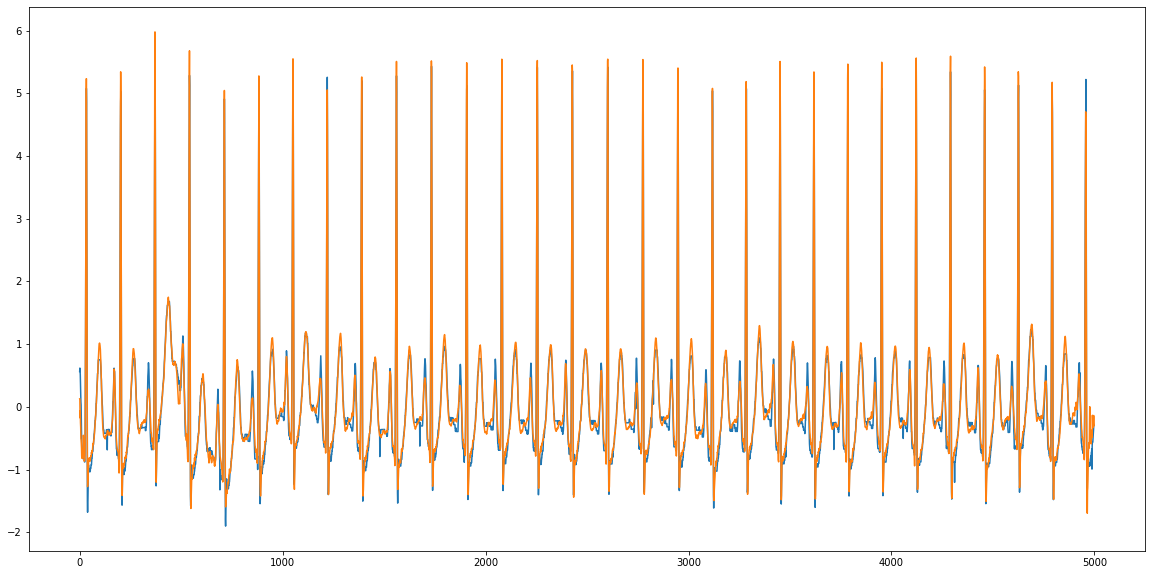

In [53]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
idx = 1200
plt.plot(x_test_ecg[idx,:,0])
plt.plot(y_pred[idx,:,0])


### test set evaluation

In [57]:
from keras.losses import MeanAbsoluteError

#y_pred = model.predict(x_test_ppg_norm)


# mae
mae = MeanAbsoluteError()
mae_val = mae(x_test_ppg, y_pred).numpy()
print('mae of test set: {:.4f}'.format(mae_val))


# precentage RMS difference
prd = np.sqrt(np.sum((y_pred-x_test_ppg)**2) / np.sum(x_test_ppg**2))*100


# compression ratio
enc_feat = K.int_shape(model.get_layer('encoder_output').output)
cr = x_test_ppg.shape[1]*x_test_ppg.shape[2]/(enc_feat[1]*enc_feat[2])
print('prd: {:.4f}%, cr: {:.2f}'.format(prd, cr))


# rename
os.rename(save_path, save_dir+'mae{:.4f}_prd{:.2f}_cr{:.2f}_{}'.format(mae_val, prd, cr, model_name))

mae of test set: 0.3718
prd: 4.8632%, cr: 16.03


In [21]:
encoder = Model(inputs=[inp_cnn], outputs=[out_inc]) 
y_enc = encoder.predict(x_test_ecg)

In [26]:
K.int_shape(out_inc)

(None, 625, 64)

In [28]:
inp_dec = Input(shape=(K.int_shape(out_inc)[1],K.int_shape(out_inc)[2]))
decoder = Model(inputs=[inp_dec], outputs=[out])

ValueError: Graph disconnected: cannot obtain value for tensor Tensor("input_4:0", shape=(None, 5000, 1), dtype=float32) at layer "conv1d_17". The following previous layers were accessed without issue: []

## Encoder output

### 원하는 layer의 output 계산

In [50]:
inp = model.input                                           # input placeholder
#inp = model2.layers[0].input


outputs = [layer.output for layer in model.layers]          # all layer outputs
functors = [K.function([inp], [out]) for out in outputs]    # evaluation functions


# Testing
test = np.random.random(input_shape)[np.newaxis,...]
layer_outs = [func([test,]) for func in functors]
print(layer_outs)

ValueError: Input tensors to a Functional must come from `tf.keras.Input`. Received: 0 (missing previous layer metadata).

### model loading

In [5]:
from keras.models import model_from_json

load_path = "output/autoencoder/input2/mae0.3718_prd4.86_cr16.03_1D_CNN_ppg_3class_custom_2"

print('loading model...', flush=True, end='')
with open(load_path+"/model.json", 'r') as f_json:
    loaded_model_json = f_json.read()
model = model_from_json(loaded_model_json)
print('done')

print('loading weights...', flush=True, end='')
load_weight_path = load_path+'/weights.hdf5'
model.load_weights(load_weight_path)
print('done')

loading model...done
loading weights...done


### encoder output

In [7]:
# output of encoder
out_enc = model.layers[12].output
print('encoder output shape:', K.int_shape(out_enc))
print('len of x_train: ', len(x_train_ppg))


inp = model.input
layer_out = K.function([inp], [out_enc])


# batch에 대해서 계산
encoder_output = []
for num in range(x_train_ppg.shape[0]//1024):
    batch = x_train_ppg[num*1024:(num+1)*1024]
    encoder_output.extend(layer_out([batch]))

encoder_out = np.reshape(encoder_output, [-1,K.int_shape(out_enc)[1],K.int_shape(out_enc)[2]])   # [-1,625,64]

num+=1
batch = x_train_ppg[num*1024:(num+1)*1024]
encoder_out = np.concatenate([encoder_out, np.array(layer_out([batch])).reshape(-1,K.int_shape(out_enc)[1],K.int_shape(out_enc)[2])], axis=0)


print('calculated encoder output shape:', encoder_out.shape)

encoder output shape: (None, 312, 1)
len of x_train:  74636
calculated encoder output shape: (74636, 312, 1)


#### embedding features

In [48]:
import skimage.measure

# global max pooling method 1
out_maxpool = skimage.measure.block_reduce(encoder_out, (1,K.int_shape(out_enc)[1], 1), np.max)
out_maxpool = out_maxpool.reshape(-1,K.int_shape(out_enc)[2])

# global max pooling method 2
#out_maxpool = encoder_out.reshape(encoder_out.shape[0],64)
#max_idx = np.argmax(encoder_out, axis = 1)
#encoder_out[max_idx]

# global average pooling mtehod
out_averagepool = skimage.measure.block_reduce(encoder_out, (1,K.int_shape(out_enc)[1], 1), np.average)
out_averagepool = out_averagepool.reshape(-1,K.int_shape(out_enc)[2])

In [49]:
out_maxpool.shape

(74636, 64)

### K-means clustering

In [54]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=2, n_init=20, n_jobs=16)
y_pred_kmeans = kmeans.fit_predict(out_averagepool)

/usr/local/lib/python3.6/dist-packages/sklearn/cluster/_kmeans.py:939: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.
  " removed in 0.25.", FutureWarning)


#### confusion matrix

<AxesSubplot:title={'center':'CM of train set with K-means cluster(3 class, averagepool)'}, xlabel='Predicted label', ylabel='True label'>

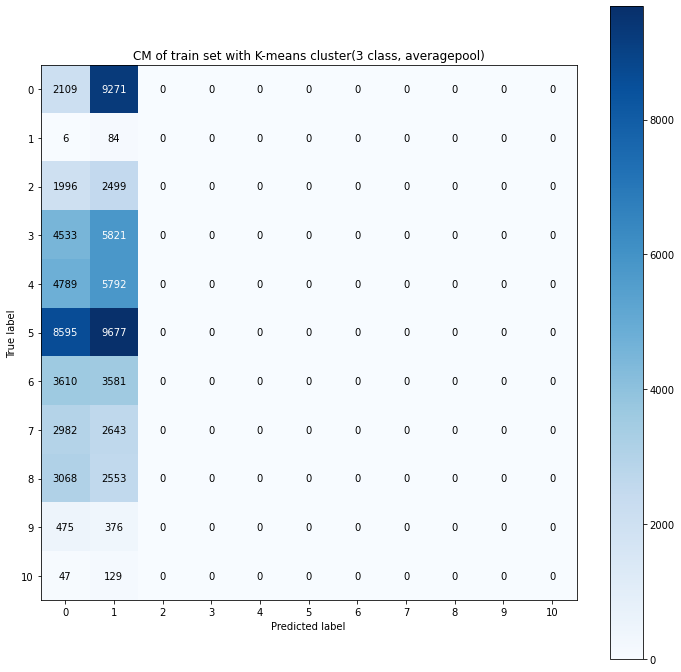

In [55]:
from scikitplot.metrics import plot_confusion_matrix
from sklearn.cluster import KMeans


# K-Means clustering
kmeans = KMeans(n_clusters=2, n_init=20, n_jobs=16)
y_pred_kmeans = kmeans.fit_predict(out_averagepool)

# plotting confusion matrix
plot_confusion_matrix(
    y_train, y_pred_kmeans, title='CM of train set with K-means cluster(3 class, averagepool)',
    figsize=(12,12))

<AxesSubplot:title={'center':'CM of train set with K-means cluster(3 class) method'}, xlabel='Predicted label', ylabel='True label'>

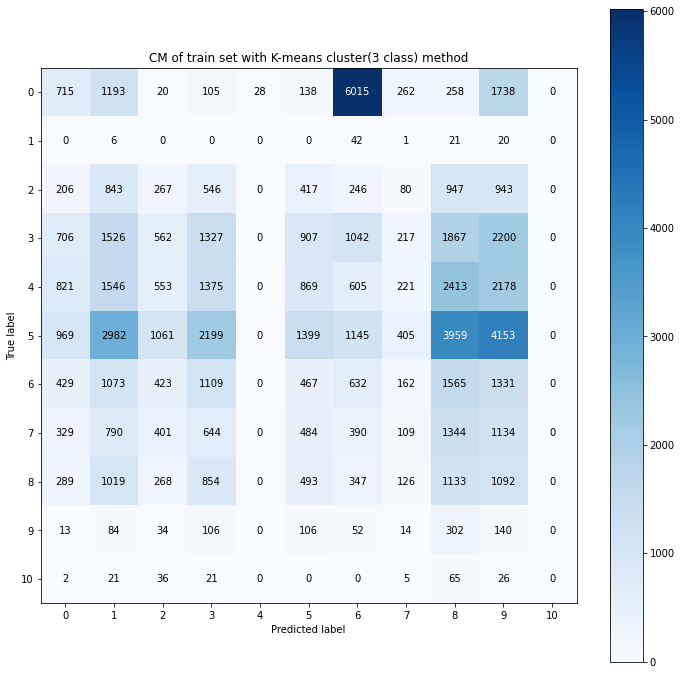

In [51]:
from scikitplot.metrics import plot_confusion_matrix


plot_confusion_matrix(
    y_train[:73728], y_pred_kmeans10, title='CM of train set with K-means cluster(3 class, maxpool)',
    figsize=(12,12))

In [ ]:
clus_train = np.ones(len(y_train))
clus_train[y_train<4] = 0
clus_train[4<=y_train<7] = 1


## Training with encoder output

In [5]:
#inp = model.input
#layer_out = K.function([inp], [model.layers[-1].output])


val_out = model.predict(x_val_ecg)

In [10]:
encoder_out.shape

(74636, 625, 64)

# Plotting

In [6]:
# output of encoder
out_enc = model.layers[12].output
print('encoder output shape:', K.int_shape(out_enc))
print('len of x_train: ', len(x_train_ppg))


inp = model.input
layer_out = K.function([inp], [out_enc])


encoder output shape: (None, 312, 1)
len of x_train:  74636


In [ ]:
plt.plot(layer_out([x_test_ppg[0]]))

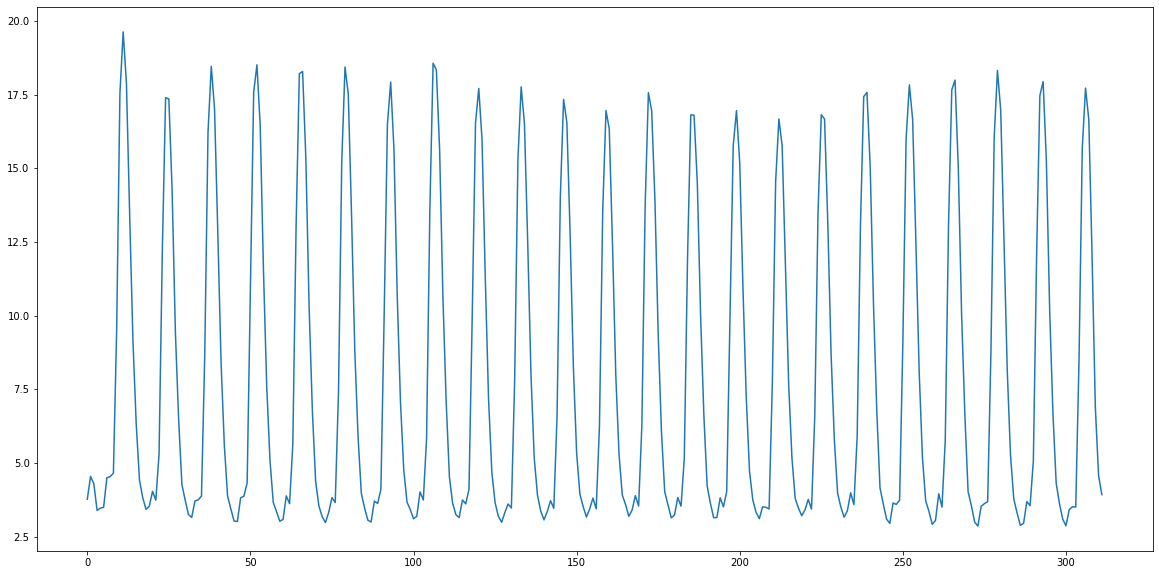

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
idx = 20000
plt.plot(encoder_out[idx,:,0])



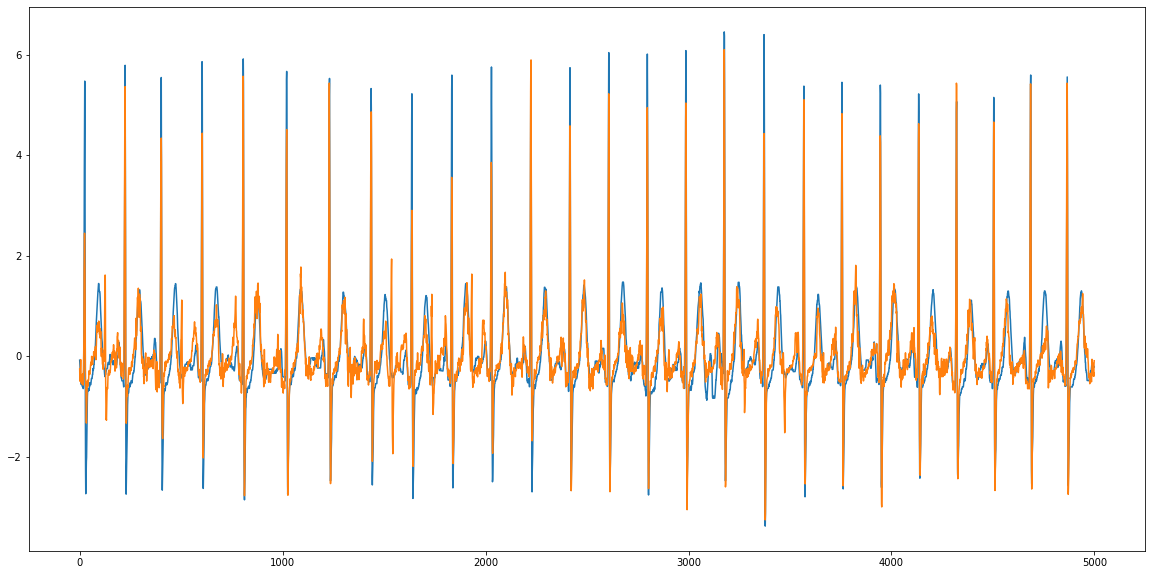

In [30]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
idx = 60
plt.plot(x_test_ecg[idx,:,0])
plt.plot(y_pred[idx,:,0])


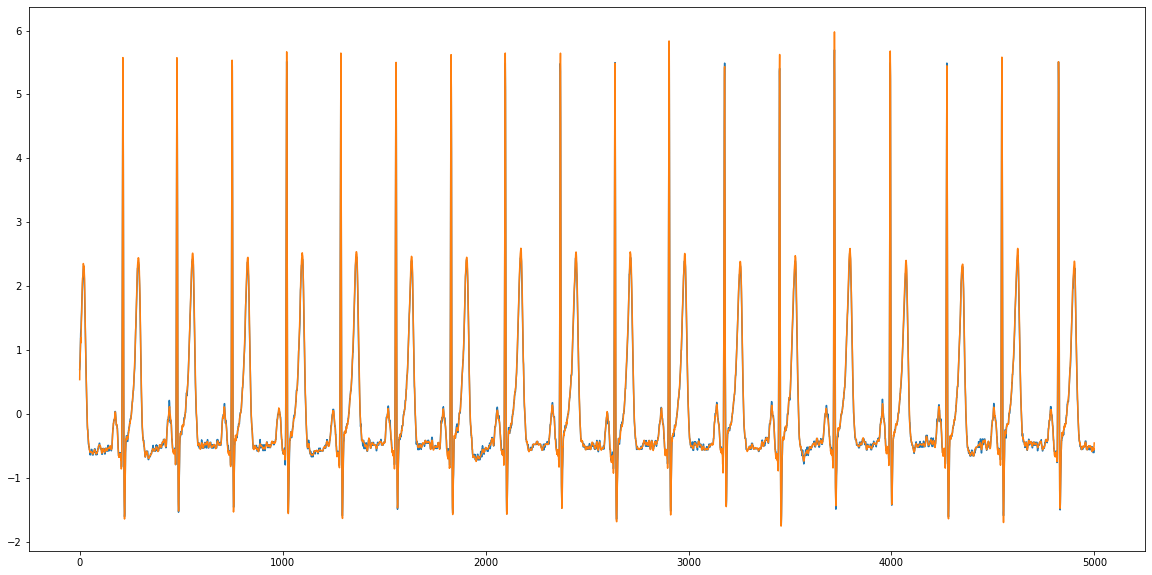

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
idx = 10
plt.plot(x_val_ecg[idx,:,0])
plt.plot(val_out[idx,:,0])


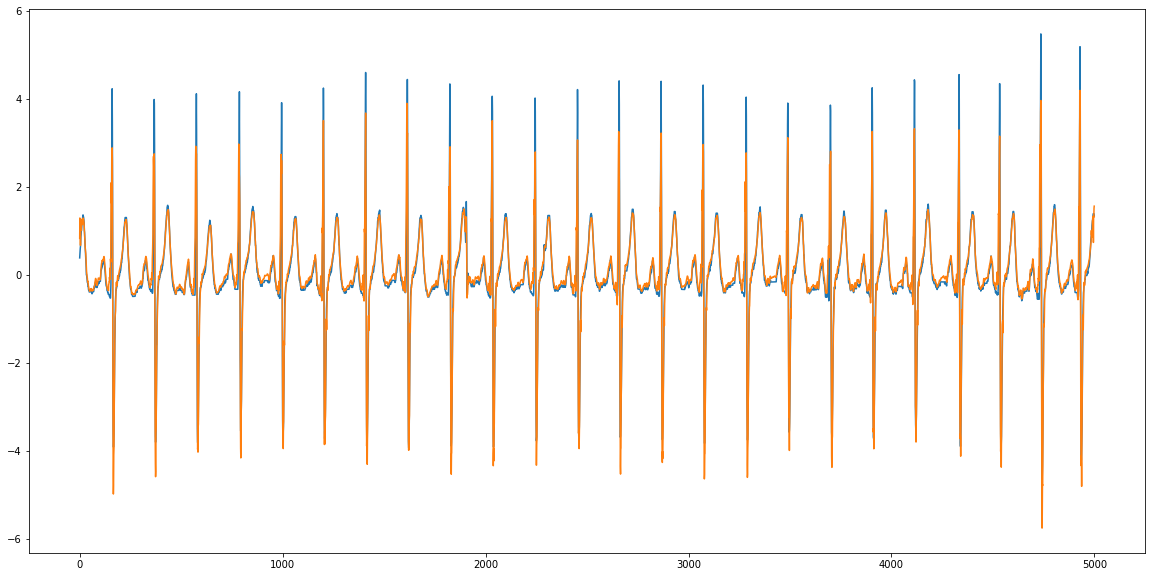

In [14]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
idx = 10
plt.plot(x_test_ecg[idx,:,0])
plt.plot(y_pred[idx,:,0])

In [19]:
import os, datetime, shutil

f_dir = '1D-CNN_age+gender/PPG_100Hz/pacu/NRS>=3/1D_CNN_3layers_train_w_samp3_lowess_filtered_large_kernel'
f_dir_mod = '1D-CNN_age+gender/PPG_100Hz/pacu/NRS>=5/1D_CNN_3layers_train_w_samp3_lowess_filtered_large_kernel'
f_list = os.listdir(f_dir)


cnt = 0
#print(datetime.datetime.now())
date_init = datetime.datetime.strptime('2020-12-23 7:53:00', '%Y-%m-%d %H:%M:%S')
for file in f_list:
    f_date = datetime.datetime.fromtimestamp(os.path.getmtime(os.path.join(f_dir, file)))
    
    if f_date > date_init:
        shutil.move(os.path.join(f_dir, file), os.path.join(f_dir_mod, file))
        cnt+=1
                
print(cnt)
    

333
